# Tutorial from Havard University Applied Math 216 course, Week 3 Section Notebook

For full original tutorial with original outputs please reference https://colab.research.google.com/drive/1bp45JyWXzB1mBj_smlAmf8SHOE7ay7sR#scrollTo=b7tMzjTs9Tje

Code in this notebook was updated from the original by Katherine Ellis in fall of 2025

To run this code locally on your machine you will need the following packages:

jax, matplotlib, numpy, diffrax, scipy

# **Inverting the laws of physics with JAX**

[JAX](https://github.com/google/jax/) is a Python library that transforms numpy-based Python code so that you can


*   Take the derivative of a function via [Autograd](https://github.com/hips/autograd)
*   Just-in-time (JIT) compile a function to run efficiently on an accelerator via [XLA](https://www.tensorflow.org/xla/)
*   Vectorize a function to process a "batch" of data in parallel

So if you write a Python function including loops/ifs/recursion/etc that takes parameter $w$ to compute $y$, you can easily obtain $\frac{dy}{dw}$ and higher-order derivatives to optimize the function using JAX.

In this notebook, you will learn the basics of JAX, build a simple Neural network, and solve simple ordinary differential equations (ODE).

## 1. JAX basics

*Most of the notebook is adopted from [JAX quickstart page](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html).

### *Taking the derivative*
Let's quickly review how one would take the derivative using computer.

* **Symbolic differentiation:** automatic manipulation of mathematical expressions to get derivatives
    - Takes a math expression and returns a math expression: $f(x) = x^2 \rightarrow \frac{df(x)}{dx} = 2x$
    - Used in Mathematica, Maple, Sympy, etc.
* **Numeric differentiation:** Approximating derivatives by finite differences:
$$
\frac{\partial}{\partial x_i} f(x_1, \dots, x_N) = \lim_{h \to 0} \frac{f(x_1, \dots, x_i + h, \dots, x_N) - f(x_1, \dots, x_i - h, \dots, x_N)}{2h}
$$
* **Automatic differentiation (JAX):** Takes code that computes a function and returns code that computes the derivative of that function.
    - Reverse Mode AD: A method to get exact derivatives efficiently, by storing information as you go forward that you can reuse as you go backwards
    - "The goal isn't to obtain closed-form solutions, but to be able to wirte a program that efficiently computes the derivatives." - (See eg Lecture 6 Slides from Univ. Toronto)http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/slides/lec6.pdf

Here is a simple example how to use `jax.grad`. It takes a function as input and returns a new function which computes the gradient of the original function.

In [1]:
import jax.numpy as np  # JAX-based numpy
from jax import grad

In [2]:
def f(x):
    return x**2 + 3*x

derivative_fn = grad(f)   # df/dx = 2*x + 3
dfdx = derivative_fn(2.)
print(dfdx)

7.0


That was easy! Let's now give multiple input values as an array.

In [3]:
def sum_logistic(x):
    return np.sum(1.0 / (1.0 + np.exp(-x)))   # need a single scalar output

x_small = np.arange(3.)
derivative_fn = grad(sum_logistic)
dfdx = derivative_fn(x_small)
print(dfdx)

[0.25       0.19661194 0.10499357]


Let's compare the results with finite difference method.

In [4]:
def finite_differences(f, x):
    eps = 1e-3
    return np.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                     for v in np.eye(len(x))])

print(finite_differences(sum_logistic, x_small))

[0.24998187 0.1965761  0.10502338]


### *JIT compilation and XLA*
JAX runs transparently on the GPU or TPU (or CPU, if you don't have these) through XLA, which is a special compiler for linear algebra calculation. However, JAX dispatches XLA-optimized kernels of your function to GPU one operation at a time. Therefore, in `sum_logistic` example where we give an array of input, there are three separate kernel dispatches.

We can use `jax.jit` to turn a function into XLA-optimized kernels once and for all. The kernel will be cached and reused for multiple operations.

In [5]:
x = np.linspace(0, 10., 1000000)

%timeit sum_logistic(x).block_until_ready()

767 µs ± 81.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
from jax import jit

sum_logistic_jit = jit(sum_logistic)
%timeit sum_logistic_jit(x).block_until_ready()

136 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


For `sum_logistic`, we gain about 6x speedup simply by wrapping the function using `jit`.

### *Vectorization to handle batch*

JAX has one more transformation in its API that you might find useful: vmap, the vectorizing map. It has the familiar semantics of mapping a function along array axes, but instead of keeping the loop on the outside, it pushes the loop down into a function’s primitive operations for better performance.

We will show you how to use `vmap` using a matrix multiplicaiton example. Let's first generate random weights and vectors.

In [7]:
# Here is how you generate random numbers
from jax import random
key = random.PRNGKey(0)   # similar to np.random.seed(0)
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))   # we have 10 batches

In [8]:
def apply_matrix(v):
    return np.dot(mat, v)

# Naive looping
def naively_batched_apply_matrix(v_batched):
    return np.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
2.94 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
from jax import vmap
def vmap_batched_apply_matrix(v_batched):
    return vmap(apply_matrix)(v_batched)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
1.33 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


We've now covered JAX's main function transformations, `grad`, `jit`, and `vmap`.

## 2. Fitting a differential equation using JAX
This example is taken from [this blogpost](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-4c6aa7b31c51/). Take a look at the diagram of 1-hidden layer NN in the link before you proceed.

The objective here is to train a neural network to find an unknown function $y=f(x)$, which is defined by a differential equation $y'=-2xy$ and an initial condition, $y(0)=2$

In [10]:
# non-linearity
def sigmoid(x):
    return 1./(1. + np.exp(-x))

# single hidden layer NN
def f(params, x):
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]
    b1 = params[30]
    x = sigmoid(x*w0 + b0)
    x = sigmoid(np.sum(x*w1) + b1)
    return x

# initilize weight
params = random.normal(key, shape=(31,))

# input coordinates
inputs = np.linspace(-2., 2., num=401)

When a function takes multiple arguments, you should specify the position of
the argument you want to take gradient against.

In [11]:
# gradient function
dfdx = grad(f, 1)   # we are taking a gradient w.r.t. the 2nd param, x.

Note that `f` and `grad(f, 1)` expect a single scalar value as `x`. We will use `vmap` to vectorize these functions over "batches" of x's.

In [12]:
f_vect = vmap(f, in_axes=(None, 0))   # vectorization mapping is placed over 2nd argument, x
dfdx_vect = vmap(dfdx, in_axes=(None, 0))   # "None" argument will be broadcasted

How do we define a loss function? We simply move terms in differential equation and initial condition to one side:

$$\begin{align}
y'=-2xy \quad &\Longrightarrow \quad y'+2xy \rightarrow 0 \\
y(0)=1 \quad &\Longrightarrow \quad y(0)-1 \rightarrow 0 \\
\end{align}
$$

If our neural network is approximating $y$ well enough, these expressions should approach zero.


In [13]:
# MSE loss
@jit  # here is another way to JIT-ify a function using @jit decorator
def loss(params, inputs):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs)
    ic = f(params, 0.) - 1.
    return np.mean(eq**2) + ic**2

grad_loss = jit(grad(loss, 0))  # now, we take a gradient w.r.t. model parameters

In [14]:
epochs = 40000
learning_rate = 3.
params = random.normal(key, shape=(31,))
for epoch in range(epochs):
    if (epoch+1) % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch+1, loss(params, inputs)))
    gradient = grad_loss(params, inputs)
    params -= learning_rate*gradient

epoch: 1000 loss: 0.999587
epoch: 2000 loss: 0.999997
epoch: 3000 loss: 0.999997
epoch: 4000 loss: 0.999997
epoch: 5000 loss: 0.999997
epoch: 6000 loss: 0.999997
epoch: 7000 loss: 0.999997
epoch: 8000 loss: 0.999996
epoch: 9000 loss: 0.999996
epoch: 10000 loss: 0.999996
epoch: 11000 loss: 0.999996
epoch: 12000 loss: 0.999995
epoch: 13000 loss: 0.999995
epoch: 14000 loss: 0.999995
epoch: 15000 loss: 0.999994
epoch: 16000 loss: 0.999994
epoch: 17000 loss: 0.999993
epoch: 18000 loss: 0.999993
epoch: 19000 loss: 0.999992
epoch: 20000 loss: 0.999991
epoch: 21000 loss: 0.999989
epoch: 22000 loss: 0.999988
epoch: 23000 loss: 0.999985
epoch: 24000 loss: 0.999981
epoch: 25000 loss: 0.999975
epoch: 26000 loss: 0.999963
epoch: 27000 loss: 0.999928
epoch: 28000 loss: 0.999337
epoch: 29000 loss: 0.007378
epoch: 30000 loss: 0.003345
epoch: 31000 loss: 0.002609
epoch: 32000 loss: 0.001639
epoch: 33000 loss: 0.000913
epoch: 34000 loss: 0.000627
epoch: 35000 loss: 0.000556
epoch: 36000 loss: 0.000509
e

Text(0, 0.5, 'y')

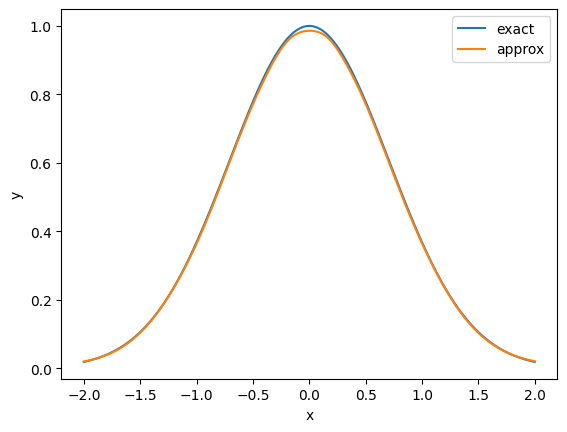

In [15]:
import matplotlib.pyplot as plt

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

Our neural network model of $y(x)$ approximates the analytical solution of $y'=-2xy$ pretty well.

To recap, we used `jax.grad` to differentiate $y$ with respect to $x$ inside the loss function, and `loss` with respect to the model paramters for parameter optimization.

### 3. Solving a differential equation using JAX

Wait, but did we really have to use this fancy JAX-based neural network to come up with the solution of ODE $y'=-2xy$?

No, we could've simply used `odeint` function to evolve the equation.

Text(0, 0.5, 'y')

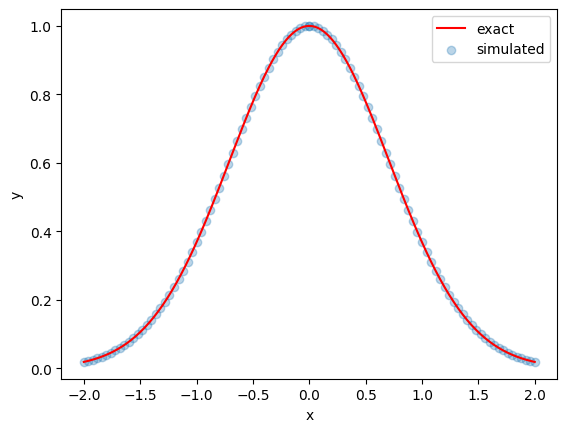

In [16]:
import scipy.integrate as sp_integrate

# define ode
def eq(y, x):
    dydx = -2 * x * y
    return dydx

# setup: I.C. and x coordinates
y0 = 1.
x_right = np.linspace(0., 2, 51)
x_left = np.linspace(0., -2., 51)

# integrate
y_right = sp_integrate.odeint(eq, y0, x_right)
y_left = sp_integrate.odeint(eq, y0, x_left)

# plot
x = list(x_left)[::-1]+list(x_right)
y_simulated = list(y_left)[::-1] + list(y_right)
plt.plot(inputs, np.exp(-inputs**2), c='r', label='exact')
plt.scatter(x, y_simulated,  alpha=0.3, label='simulated')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

The simulated solution matches the exact solution.

Now, consider the following inverse problem: **given data points of $y(x)$, find the parameters of an ODE $\dot{y}(x)=f(x, y)$.** We immediately recognize that we can't write down `eq` part of the loss function, so neural network method is hopeless. Can the above integration method help?

Fortunately, using `jax.experimental.ode.odeint`, we can


1.   Integrate an ODE
2.   Compare the integrated solution and real data through loss
3.   Take derivatives of the loss w.r.t. ODE parameters or initial conditions (gradient flows through an integrator)
4.   Optimize parameters or initial conditions using gradient descent.

to solve the inverse problem.

#### 3.a. finding acceleration and initial condition of Newton's law

In this example, the groud truth trajectory is obtained by solving $\dot{y}(t) = 2t$ with an initial condition $y(0) = 0$.

In [17]:
!pip install diffrax
#note this code should only need to be run once to get diffrax into your local directory for google colab to use

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.4 MB/s eta 0:00:00


In [18]:
# Code updated from original tutorial by Katherine Ellis in fall of 2025
# Original code used the following packages which are no longer supported so the code was reworked to use diffrax:
# from jax.experimental.ode import build_odeint   # JAX's differentiable odeint
# the original code cell will be copied at the end of this notebook for reference

import numpy as np
import diffrax as dfx
import jax.numpy as jnp

# define ode
def Newton(y, t, a):
    dydt = a*t
    return dydt


# setup: I.C., ode parameter and t coordinates
# Setup initial conditions and parameters
y0_real = jnp.array(0.0)
a_real = jnp.array(2.0)
t0, t1 = 0.0, 9.0
ts = np.arange(t0, t1 + 1.0, 1.0)  # use NumPy array for SaveAt
print("The real acceleration of the object is:", a_real)
print("The object starts at y0=",y0_real)

def integrate(y0, a):
    term = dfx.ODETerm(Newton)
    solver = dfx.Dopri5()
    saveat = dfx.SaveAt(ts=ts)
    sol = dfx.diffeqsolve(
        terms=term,
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=0.1,
        y0=y0,
        args=a,
        saveat=saveat
    )
    return sol.ys

# integrate
traj_true = integrate(y0_real, a_real)

# MSE loss over trajectory
def loss(a, y0):
    traj_pred = integrate(y0, a)
    return jnp.mean((traj_pred - traj_true) ** 2)

# gradient functions w.r.t. a and y0
dfda = jit(grad(loss, 0))
dfdy0 = jit(grad(loss, 1))

# Guessing y0 and a
y0 = jnp.array(-0.5)
a = jnp.array(3.0)
print("The initially guessed acceleration is:", a)
print("The initially guessed y0 is:", y0)

# learning rates
lr_a = 1e-24
lr_y0 = 1e-23

# optimization
for i in range(100):
    g_a = dfda(a, y0)
    #print(g_a)
    g_y0 = dfdy0(a, y0)
    #print(g_y0)
    if jnp.abs(g_a) < 1e-3 and jnp.abs(g_y0) < 1e-3:
        break
    a -= lr_a * g_a
    #print(lr_a * g_a)
    #print(a)
    y0 -= lr_y0 * g_y0
    #print(lr_y0 * g_y0)
    #print(y0)
    #if i%100==0:
      #print(i)

print("The finally guessed acceleration is:", a)
print("The finally guessed y0 is:", y0)

The real acceleration of the object is: 2.0
The object starts at y0= 0.0
The initially guessed acceleration is: 3.0
The initially guessed y0 is: -0.5
The finally guessed acceleration is: 2.850793
The finally guessed y0 is: -0.0035931384


Optimized parameter and initial condition match the real values.

#### 3.b. finding parameters of a pendulum with friction

The second order differential equation for the angle $\theta$ of a pendulum with friction is,

$$ \ddot{\theta}(t) + b\dot{\theta}(t) + c\sin\theta(t)=0$$

To solve the equation of motion numerically, we break it up into a system of two ODEs by introducing the angular velocity $\omega(t)$ to obtain,

$$
\begin{align*}
 \dot{\theta}(t) &= \omega(t) \\
 \dot{\omega}(t) &= -b\omega(t) - c\sin\theta(t)
\end{align*}
$$

In this example, the ground truth trajectories of $\theta$ and $\omega$ are generated using an initial condition of $\theta(0)=\pi-1$ and $\omega(0) = 0$, and parameters $b=0.25$ and $c=5$.

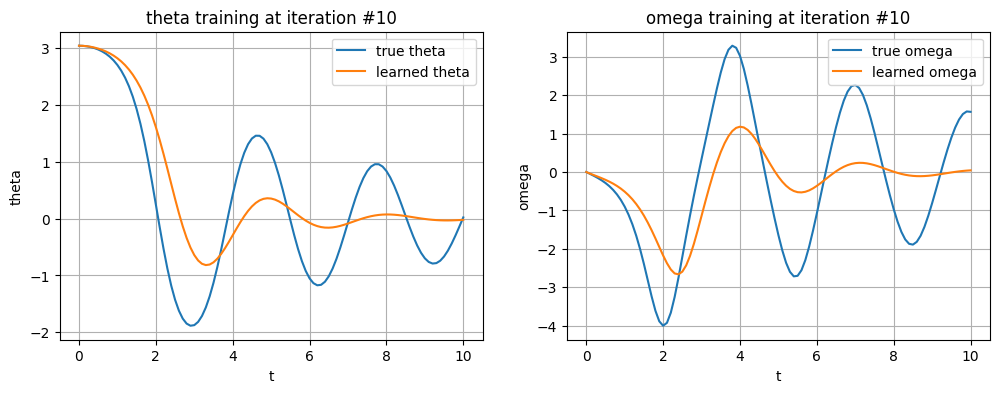

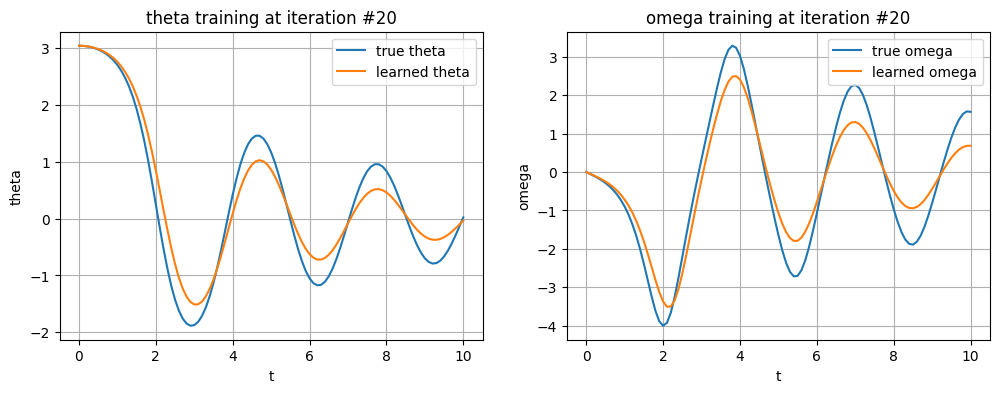

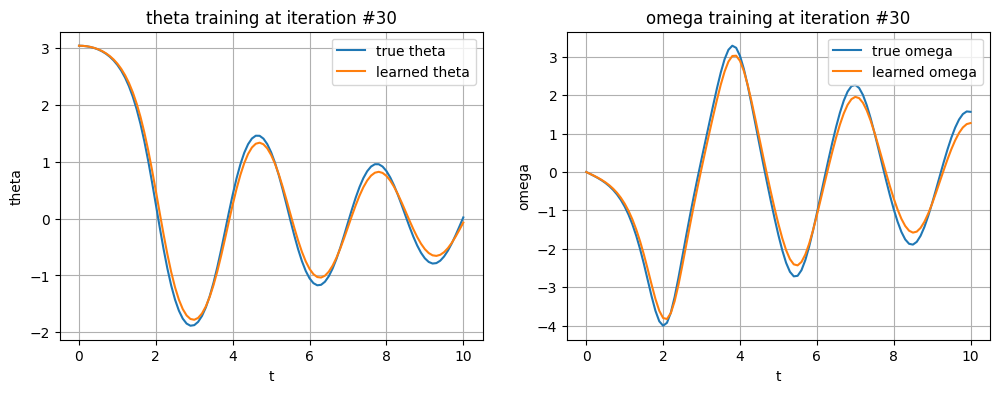

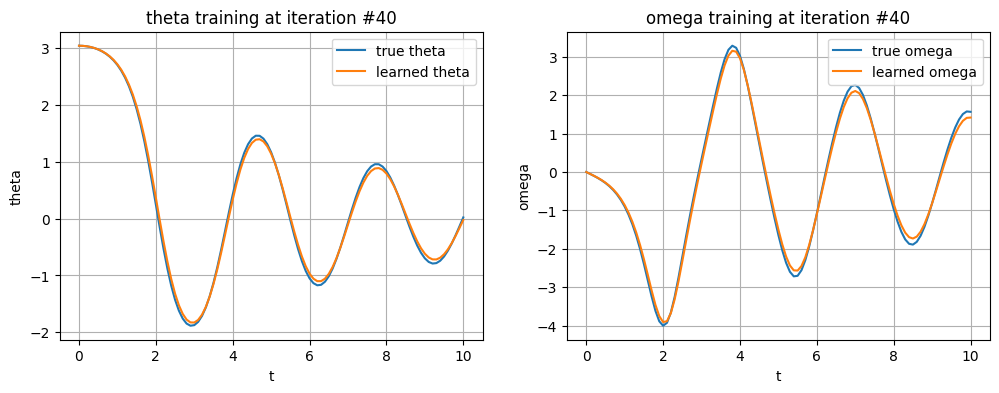

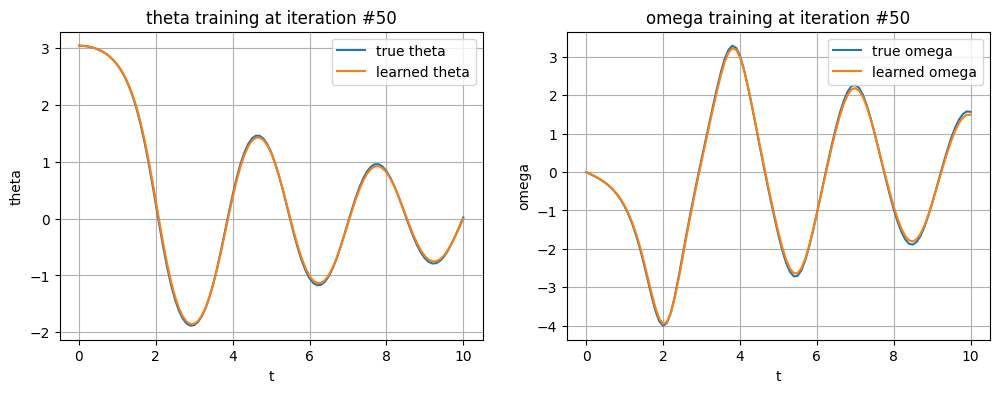

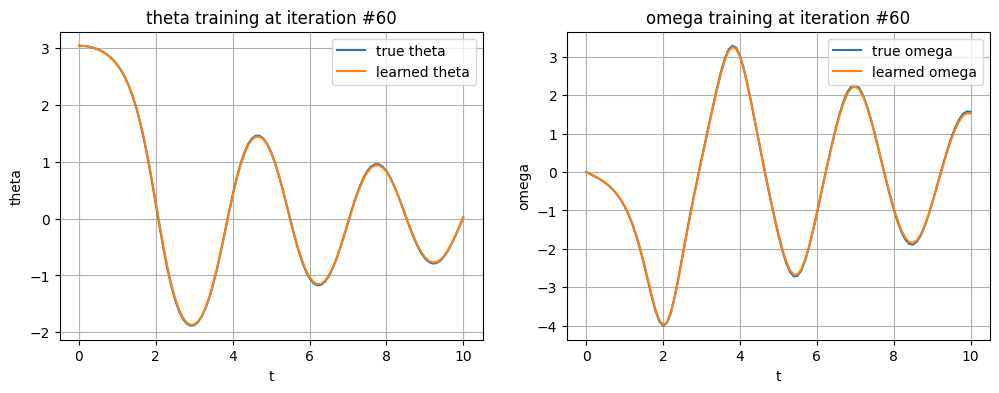

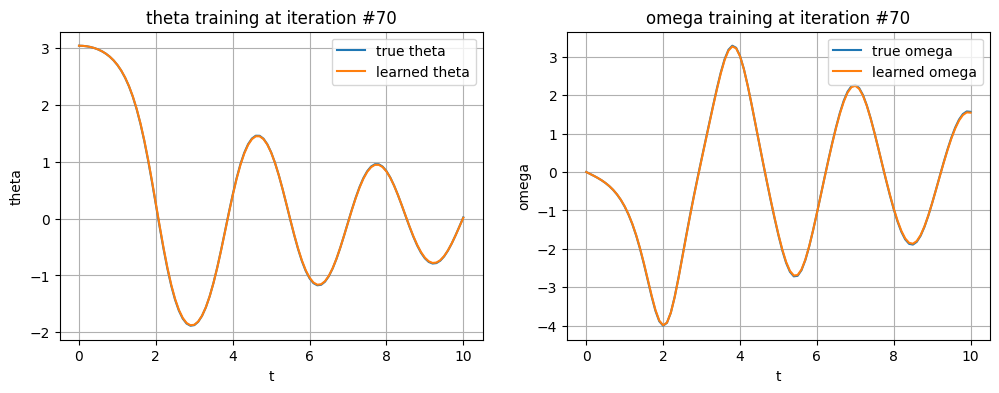

training ended at 77 iteration
learned b: 0.2519744336605072 	 true b: 0.25
learned c: 4.990047931671143 	 true c: 5.0


In [19]:
# Code updated from original tutorial by Katherine Ellis in fall of 2025
# Original code used the following packages which are no longer supported so the code was reworked to use diffrax:
# from jax.experimental.ode import build_odeint   # JAX's differentiable odeint
# the original code cell will be copied at the end of this notebook for reference

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import diffrax

def pendulum(t, y, args):
    b, c = args
    theta, omega = y
    return jnp.array([
        omega,
        -b * omega - c * jnp.sin(theta)
    ])

# DO NOT use float() on JAX arrays!
def solve_pendulum_ode(y0, t, b, c):
    solver = diffrax.Tsit5()
    saveat = diffrax.SaveAt(ts=t)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(pendulum),
        solver,
        t0=t[0],      # <-- this is crucial!
        t1=t[-1],
        dt0=0.1,
        y0=y0,
        args=(b, c),
        saveat=saveat
    )
    return sol.ys

y0 = jnp.array([jnp.pi - 0.1, 0.0])
t = jnp.linspace(0., 10., 101)
b = 0.25
c = 5.0
true_traj = solve_pendulum_ode(y0, t, b, c)

b_guess = 1.5
c_guess = 4.0

def loss(b, c):
    pred = solve_pendulum_ode(y0, t, b, c)
    return jnp.sum((pred - true_traj)**2)

grad_b = jax.jit(jax.grad(loss, 0))
grad_c = jax.jit(jax.grad(loss, 1))

learning_rate = 0.0002
epochs = 1000
tol = 1e-2

for epoch in range(epochs):
    b_guess -= learning_rate * grad_b(b_guess, c_guess)
    c_guess -= learning_rate * grad_c(b_guess, c_guess)

    if (epoch + 1) % 10 == 0:
        cur_traj = solve_pendulum_ode(y0, t, b_guess, c_guess)
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        for i, variable in enumerate(['theta', 'omega']):
            ax[i].plot(t, true_traj[:, i], label=f'true {variable}')
            ax[i].plot(t, cur_traj[:, i], label=f'learned {variable}')
            ax[i].set_xlabel('t')
            ax[i].set_ylabel(f'{variable}')
            ax[i].set_title(f'{variable} training at iteration #{epoch+1}')
            ax[i].grid()
            ax[i].legend()
        plt.show()

    if jnp.abs(b - b_guess) < tol and jnp.abs(c - c_guess) < tol:
        print(f'training ended at {epoch+1} iteration')
        print(f'learned b: {b_guess} \t true b: {b}')
        print(f'learned c: {c_guess} \t true c: {c}')
        break

Voila! The integrated trajectories converge toward the ground truth trajectories as training proresses.

**Exercise**

1.   Start training from overdamped regime. Can you still recover true $b$ and $c$ values?
2.   Try optimizing initial condition of $\theta$ and $\omega$'s as well.



In [21]:
# Code written by Katherine Ellis in fall 2025

import numpy as np
import diffrax as dfx
import jax.numpy as jnp


# define ode
def Decay(y, t, a):
    dydt = -a*y
    return dydt


# setup: I.C., ode parameter and t coordinates
# Setup initial conditions and parameters
y0_real = jnp.array(100)
a_real = jnp.array(2.0)
t0, t1 = 0.0, 9.0
ts = np.arange(t0, t1 + 1.0, 1.0)  # use NumPy array for SaveAt
print("The real lambda of the Decay is:", a_real)
print("The Decay starts at N=",y0_real)

def integrate(y0, a):
    term = dfx.ODETerm(Decay)
    solver = dfx.Dopri5()
    saveat = dfx.SaveAt(ts=ts)
    sol = dfx.diffeqsolve(
        terms=term,
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=0.1,
        y0=y0,
        args=a,
        saveat=saveat
    )
    return sol.ys

# integrate
traj_true = integrate(y0_real, a_real)

# MSE loss over trajectory
def loss(a, y0):
    traj_pred = integrate(y0, a)
    return jnp.mean((traj_pred - traj_true) ** 2)

# gradient functions w.r.t. a and y0
dfda = jit(grad(loss, 0))
dfdy0 = jit(grad(loss, 1))

# Guessing y0 and a
y0 = jnp.array(110.0)
a = jnp.array(1.5)
print("The initially guessed lambda of Decay is:", a)
print("The initially guessed N is:", y0)

# learning rates
# depending
lr_a = 1e-5
lr_y0 = 1e-3

# optimization
for i in range(100):
    g_a = dfda(a, y0)
    g_y0 = dfdy0(a, y0)
    if jnp.abs(g_a) < 1e-3 and jnp.abs(g_y0) < 1e-3:
        break
    a -= lr_a * g_a
    y0 -= lr_y0 * g_y0
    if i%1000 == 0:
      print(i)

print("The finally guessed lambda of Decay is:", a)
print("The finally guessed N is:", y0)

The real lambda of the Decay is: 2.0
The Decay starts at N= 100
The initially guessed lambda of Decay is: 1.5
The initially guessed N is: 110.0
0
The finally guessed lambda of Decay is: 1.9379318
The finally guessed N is: 107.55865


# Original Tutorial Code for 3a

In [ ]:
#Original tutorial code for the 3b
# note jax.experimental.ode does is no longer supported so this code cell wont run

from jax.experimental.ode import build_odeint   # JAX's differentiable odeint

# define ode
def Newton(y, t, a):
    dydt = a*t
    return dydt
Newton_odeint = build_odeint(Newton)

# setup: I.C., ode parameter and t coordinates
y0_real = np.array([0.])  # JAX's odeint expects jax.np.array
a_real = np.array([2.])
t = np.arange(10.)
print("The real acceleration of the object is:", a_real[0])
print("The object starts at y0=",y0_real[0])

# integrate
traj_true = Newton_odeint(y0_real, t, a_real)

# MSE loss over trajectory
def loss(a, y0):
    return np.sum((Newton_odeint(y0, t, a).reshape(-1)-traj_true.reshape(-1))**2)

# gradient functions w.r.t. a and y0
dfda = jit(grad(loss, 0))
dfdy0 = jit(grad(loss, 1))

# Guessing y0 and a
y0 = np.array([-0.5])
a = np.array([3.])
print("The initially guessed acceleration is:", a[0])
print("The initially guessed y0 is:", y0[0])

# learning rates
lr_a = 0.00025
lr_y0 = 0.03

# optimization
while np.abs(dfda(a,y0)) > 1e-3 or np.abs(dfdy0(a,y0)) > 1e-3:
    a -= lr_a * dfda(a,y0)
    y0 -= lr_y0 * dfdy0(a,y0)
print("The finally guessed acceleration is:", a[0])
print("The finally guessed y0 is:", y0[0])

# Original Tutorial Code for 3b

In [ ]:
#Original tutorial code for the 3b
# note jax.experimental.ode does is no longer supported so this code cell wont run

## Pendulum
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

'''
theta''(t) + b*theta'(t) + c*sin(theta(t)) = 0
theta'(t) = omega(t)
omega'(t) = -b*omega(t) - c*sin(theta(t))
'''

def pendulum(y, t, b, c):
    theta, omega = y
    dydt = np.array([omega, -b*omega - c*np.sin(theta)])
    return dydt
#built = build_odeint(pendulum)

# generate ground truth trajectory
y0 = np.array((np.pi - 0.1, 0.0)) # I.C.
t = np.linspace(0., 10., 101)
b = 0.25
c = 5.0
true_traj = odeint(pendulum, y0, t, b, c)

# find parameter b and c with JAX
b_guess = 1.5
c_guess = 4.

def loss(b, c):
    return np.sum((odeint(pendulum, y0, t, b, c) - true_traj)**2)

grad_b = jit(grad(loss, 0))
grad_c = jit(grad(loss, 1))

learning_rate = 0.0002
epochs = 1000  #
tol = 1e-2
for epoch in range(epochs):
    b_guess -= learning_rate * grad_b(b_guess,c_guess)
    c_guess -= learning_rate * grad_c(b_guess,c_guess)

    # check how learned ODE fares aginst the real trajectory
    if (epoch+1) % 10 == 0:
        cur_traj = odeint(pendulum, y0, t, b_guess, c_guess)
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        for i, variable in enumerate(['theta', 'omega']):
            ax[i].plot(t, true_traj[:, i], label=f'true {variable}')
            ax[i].plot(t, cur_traj[:, i], label=f'learned {variable}')
            ax[i].set_xlabel('t')
            ax[i].set_ylabel(f'{variable}')
            ax[i].set_title(f'{variable} training at iteration #{epoch+1} ')
            ax[i].grid()
            ax[i].legend()
        plt.show()

    # break condition
    if np.abs(b-b_guess) < tol and np.abs(c-c_guess) < tol:
        print(f'training ended at {epoch+1} iteration')
        print(f'learned b: {b_guess} \t true b: {b}')
        print(f'learned c: {c_guess} \t true c: {c}')
        break